In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.io import imread
from sklearn.model_selection import train_test_split
import keras
from keras import Sequential
from keras.applications import MobileNetV2
from keras.layers import Dense
from tensorflow.keras.preprocessing import image

In [2]:
df = pd.read_csv('Brain Tumor.csv',usecols=[0,1])
df.head()

,Image,Class
0,Image1,0
1,Image2,0
2,Image3,1
3,Image4,1
4,Image5,0


In [3]:
# checking for null values
df.isna().sum()

Image    0
Class    0
dtype: int64

C:\Users\Surya\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


0    2079
1    1683
Name: Class, dtype: int64

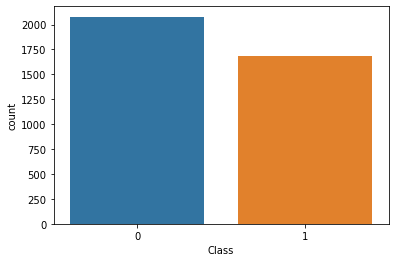

In [4]:
# plot the value count
sns.countplot(df['Class'])

# checking imbalanceness of data
df['Class'].value_counts()

In [5]:
path_list = []
base_path = 'Brain Tumor'
for entry in os.listdir(base_path):
    path_list.append( os.path.join(base_path,entry))
    
#create path dictonary and then map itto df['pathes']
pathes_dict={os.path.splitext(os.path.basename(x))[0]: x for x in path_list}
df['pathes'] = df['Image'].map(pathes_dict.get)

df.head()

,Image,Class,pathes
0,Image1,0,Brain Tumor\Image1.jpg
1,Image2,0,Brain Tumor\Image2.jpg
2,Image3,1,Brain Tumor\Image3.jpg
3,Image4,1,Brain Tumor\Image4.jpg
4,Image5,0,Brain Tumor\Image5.jpg


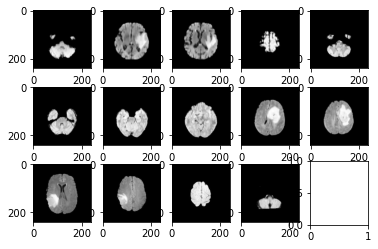

In [6]:
for x in range (0 ,15):
    img = imread(df['pathes'][x])
    plt.imshow(img)
    plt.subplot(3,5,x+1)

In [7]:
from PIL.Image import open

# resizing the image data to 224 x 224
df['pixels']=df['pathes'].map(lambda x:np.asarray(open(x).resize((224,224))))
df.head()

,Image,Class,pathes,pixels
0,Image1,0,Brain Tumor\Image1.jpg,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
1,Image2,0,Brain Tumor\Image2.jpg,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
2,Image3,1,Brain Tumor\Image3.jpg,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
3,Image4,1,Brain Tumor\Image4.jpg,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
4,Image5,0,Brain Tumor\Image5.jpg,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."


## preprocessing our dataset before using MobileNet

In [8]:
image_list = []
for i in range(0,len(df)):
    # load image
    brain_img = df['pixels'][i].astype(np.float32)
    
    img_array = image.img_to_array(brain_img)
    # append to list of all images
    image_list.append(keras.applications.mobilenet_v2.preprocess_input(img_array))
    
# convert image list to single array
X = np.array(image_list)
y = np.array(df.Class)
print(X.shape,y.shape)

(3762, 224, 224, 3) (3762,)


In [9]:
# Splitting the dataset to training set(80%) and testing set (20%)
X_train,X_test,y_train,y_test = train_test_split(X,y
                                                 ,test_size=0.2
                                                ,random_state=0)
print(X_train.shape,X_train.shape[0],X_test.shape,X_test.shape[0])

(3009, 224, 224, 3) 3009 (753, 224, 224, 3) 753


## Build model(MobileNet)

In [10]:
num_classes = 1
model = Sequential()
model.add(MobileNetV2(input_shape=(224, 224, 3),
                      weights="imagenet",
                      include_top=False))
model.add(keras.layers.GlobalAveragePooling2D())
model.add( Dense(num_classes,
                 activation='sigmoid',
                 name='preds'))
model.layers[0].trainable= False
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 preds (Dense)               (None, 1)                 1281      
                                                                 
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [11]:
# set the loss as binary_crossentropy
# set the optimizer as stochastic gradient descent
# set the metric as accuracy
model.compile(
    loss=keras.losses.binary_crossentropy,
    optimizer=keras.optimizers.SGD(lr=0.001),
    metrics=['accuracy'])

model.fit(
    X_train[:,:,:,:],
    y_train[:],
    epochs=10,
    verbose=1,
    validation_data=(X_test[:,:,:,:], y_test[:])
)

model.save("model_brain.h5")

C:\Users\Surya\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/10
95/95 [==============================] - 56s 551ms/step - loss: 0.6532 - accuracy: 0.6268 - val_loss: 0.5649 - val_accuracy: 0.7371
Epoch 2/10
95/95 [==============================] - 50s 530ms/step - loss: 0.5286 - accuracy: 0.7620 - val_loss: 0.5056 - val_accuracy: 0.7663
Epoch 3/10
95/95 [==============================] - 50s 529ms/step - loss: 0.4778 - accuracy: 0.7973 - val_loss: 0.4700 - val_accuracy: 0.7902
Epoch 4/10
95/95 [==============================] - 52s 543ms/step - loss: 0.4485 - accuracy: 0.8116 - val_loss: 0.4457 - val_accuracy: 0.8088
Epoch 5/10
95/95 [==============================] - 50s 531ms/step - loss: 0.4270 - accuracy: 0.8169 - val_loss: 0.4306 - val_accuracy: 0.8048
Epoch 6/10
95/95 [==============================] - 55s 575ms/step - loss: 0.4109 - accuracy: 0.8252 - val_loss: 0.4289 - val_accuracy: 0.8127
Epoch 7/10
95/95 [==============================] - 52s 547ms/step - loss: 0.3968 - accuracy: 0.8312 - val_loss: 0.4356 - val_accuracy: 0.8048

In [12]:
pretrained_cnn = keras.models.load_model('./model_brain.h5')

# evaluate model on holdout set
eval_score = pretrained_cnn.evaluate(X_test,y_test)
print('Loss:',round(eval_score[0],4))
print('Accuracy:',round(eval_score[1],4)*100,"%")

24/24 [==============================] - 11s 431ms/step - loss: 0.4000 - accuracy: 0.8287
Loss: 0.4
Accuracy: 82.87 %


In [13]:
y_pred = pretrained_cnn.predict(X_test)

# classification using predicted values
for i in range(len(y_pred)):
    if y_pred[i]<0.5:
        y_pred[i]=0
    else:
        y_pred[i]=1

24/24 [==============================] - 11s 431ms/step


In [14]:
from sklearn.metrics import confusion_matrix , classification_report
target_classes = ['No Tumor','Tumor']
target_classes = [0,1]
classification_report(y_test , y_pred , output_dict = True
                      , target_names=target_classes)

{0: {'precision': 0.7952069716775599,
  'recall': 0.9125,
  'f1-score': 0.8498253783469151,
  'support': 400},
 1: {'precision': 0.8809523809523809,
  'recall': 0.7337110481586402,
  'f1-score': 0.8006182380216383,
  'support': 353},
 'accuracy': 0.8286852589641435,
 'macro avg': {'precision': 0.8380796763149705,
  'recall': 0.8231055240793201,
  'f1-score': 0.8252218081842767,
  'support': 753},
 'weighted avg': {'precision': 0.8354036907665531,
  'recall': 0.8286852589641435,
  'f1-score': 0.826757489190444,
  'support': 753}}

In [15]:
confusion_matrix(y_test , y_pred ) 

array([[365,  35],
       [ 94, 259]], dtype=int64)